# General Deep Image Completion with LC GAN

In [1]:
import random

import numpy as np

import tensorflow as tf

import matplotlib.pyplot as plt

from masks import *

import dotenv

dotenv.load_dotenv(dotenv.find_dotenv())

True

In [2]:
IMAGE_SIZE = (256, 256)

## Build the generator

### Build semantic feature extraction (Encoder)

**Semantic Feature Extractor**: Given a corrupted image I with size H × W as input, we use a part of layers (before conv4-1) from VGG19 architecture as our semantic feature extractor (encoder) to obtain a high-level and semantic feature patch. To preserve image details, we replace all the pooling layer with strided convolutions as the pooling layer tens to lose some information in the reconstruction based networks. Also, we decrease the filter numbers of each layer to reduce the total model size.
Each convolution is followed by ELU activation that enhances the performance of the autoencoder.

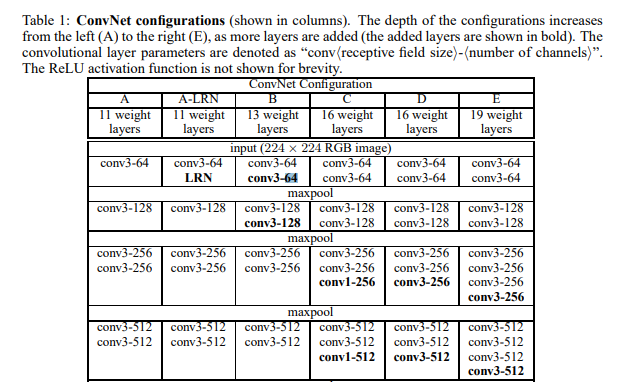

In [3]:
class SemanticFeatureExtractor(tf.keras.Model):
    def __init__(self):
        super(SemanticFeatureExtractor, self).__init__(name = 'SemanticFeatureExtractor')
        # Building table 1 VGG19 column E model's architecture
        
        # Row 1
        self.conv_3_32_1 = tf.keras.layers.Conv2D(32, kernel_size=3, padding='same')
        self.elu_1_1 = tf.keras.layers.ELU()

        self.conv_3_32_2 = tf.keras.layers.Conv2D(32, kernel_size=3, padding='same')
        self.elu_1_2 = tf.keras.layers.ELU()
        
        self.strided_conv_1 = tf.keras.layers.Conv2D(32, kernel_size=2, strides=2, padding='same')
        
        # Row 2
        self.conv_3_64_1 = tf.keras.layers.Conv2D(64, kernel_size=3, padding='same')
        self.elu_2_1 = tf.keras.layers.ELU()
        
        self.conv_3_64_2 = tf.keras.layers.Conv2D(64, kernel_size=3, padding='same')
        self.elu_2_2 = tf.keras.layers.ELU()
        
        self.strided_conv_2 = tf.keras.layers.Conv2D(64, kernel_size=2, strides=2, padding='same')
        
        # Row 3

        self.conv_3_128_1 = tf.keras.layers.Conv2D(128, kernel_size=3, padding='same')
        self.elu_3_1 = tf.keras.layers.ELU()
        
        self.conv_3_128_2 = tf.keras.layers.Conv2D(128, kernel_size=3, padding='same')
        self.elu_3_2 = tf.keras.layers.ELU()
        
        self.conv_3_128_3 = tf.keras.layers.Conv2D(128, kernel_size=3, padding='same')
        self.elu_3_3 = tf.keras.layers.ELU()
        
        self.conv_3_128_4 = tf.keras.layers.Conv2D(128, kernel_size=3, padding='same')
        self.elu_3_4 = tf.keras.layers.ELU()
        
        self.strided_conv_3 = tf.keras.layers.Conv2D(128, kernel_size=2, strides=2, padding='same')
        
    def call(self, tensor_input, training=False):
        # Row 1
        x = self.conv_3_32_1(tensor_input)
        x = self.elu_1_1(x)
        
        x = self.conv_3_32_2(x)
        x = self.elu_1_2(x)
        
        out_conv_1 = self.strided_conv_1(x)
        
        # Row 2
        x = self.conv_3_64_1(out_conv_1)
        x = self.elu_2_1(x)
        
        x = self.conv_3_64_2(x)
        x = self.elu_2_2(x)
        
        out_conv_2 = self.strided_conv_2(x)
        
        # Row 3
        x = self.conv_3_128_1(out_conv_2)
        x = self.elu_3_1(x)
        
        x = self.conv_3_128_2(x)
        x = self.elu_3_2(x)
        
        x = self.conv_3_128_3(x)
        x = self.elu_3_3(x)
        
        x = self.conv_3_128_4(x)
        x = self.elu_3_4(x)
        
        output = self.strided_conv_3(x)
        
        return output, out_conv_2, out_conv_1

Trainable parameters with an image of 256 x 256 pixels

In [4]:
model = SemanticFeatureExtractor()
model.build(input_shape=(None, 256, 256, 3))
model.summary()

Model: "SemanticFeatureExtractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
elu (ELU)                    multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  9248      
_________________________________________________________________
elu_1 (ELU)                  multiple                  0         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  4128      
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  18496     
_________________________________________________________________
elu_2 (ELU)                  multiple     

### Build the decoder

**Simple Generator**: Common deep encoder-decoder networks use symmetric structure
that extracts features and generates outcome through the same number of layers. However,
if the layer goes deeper, it would be difficult to train on GPUs efficiently due to explosion of
parameters and memory usage. In addition, the deeper structure in the decoder, the harder
to propagate learned feature information from the encoder. Therefore, we construct a simple
generator (or decoder) that takes the semantic feature patch as input and then reconstructs a
complete image in a short path. Our simple generator only contains two modules, and each
is formed of (convolution, fraction-strided convolution, ELU). Then, one convolution and
fraction-strided convolution is added at the end of the modules to produce the desired image.
Although our generator is short and simple, we can still obtain very good image reconstruction as long as we learn high-level and semantic feature patches through the encoder

In [5]:
class Decoder(tf.keras.Model):
    def __init__(self):
        super(Decoder, self).__init__(name = 'Decoder')
        
        self.conv_1 = tf.keras.layers.Conv2D(64, kernel_size=2, padding='same')
        self.deconv_1 = tf.keras.layers.Conv2DTranspose(64, kernel_size=2, strides=2, padding='same')
        self.elu_1 = tf.keras.layers.ELU()
        
        self.conv_2 = tf.keras.layers.Conv2D(32, kernel_size=2, padding='same')
        self.deconv_2 = tf.keras.layers.Conv2DTranspose(32, kernel_size=2, strides=2, padding='same')
        self.elu_2 = tf.keras.layers.ELU()
        
        self.conv_3 = tf.keras.layers.Conv2D(3, kernel_size=2, padding='same')
        self.deconv_3 = tf.keras.layers.Conv2DTranspose(3, kernel_size=2, strides=2, padding='same')
        
    def call(self, input_tensor, training=False, **kwargs):
        x = self.conv_1(input_tensor)
        x = self.deconv_1(x)
        x = self.elu_1(x)
        
        skip_1 = tf.keras.layers.concatenate([x, kwargs['strided_conv_2']], 3)
        
        x = self.conv_2(skip_1)
        x = self.deconv_2(x)
        x = self.elu_2(x)
        
        skip_2 = tf.keras.layers.concatenate([x, kwargs['strided_conv_1']], 3)
        
        x = self.conv_3(skip_2)
        x = self.deconv_3(x)
        
        return x

### Join the encoder and decoder

In [6]:
class Generator(tf.keras.Model): 
    def __init__(self):
        super(Generator, self).__init__(name = 'Generator')
        self.encoder = SemanticFeatureExtractor()
        self.decoder = Decoder()
        
    def call(self, input_tensor):
        x, out_conv_2, out_conv_1  = self.encoder(input_tensor)
        x = self.decoder(x, strided_conv_1=out_conv_1, strided_conv_2=out_conv_2)
        return x

In [7]:
model = Generator()
out = model.predict(np.random.uniform(0, 1, (1, 128, 128, 3)))
out.shape

(1, 128, 128, 3)

Generator working. Without training generates noise with noise

W0504 12:07:47.589998  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


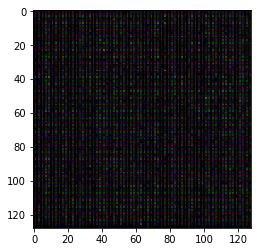

In [8]:
plt.imshow(out[0])

## Build the discriminator

Modified architecture from this [paper](https://arxiv.org/pdf/1604.07379.pdf) by using a leaky relu activation and a batch normalization after each convutional layer.

In [9]:
class Discriminator(tf.keras.Model):
    def __init__(self, **kwargs):
        super(Discriminator, self).__init__(name='Discriminator', **kwargs)
        self.conv2d_1 = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding="same")
        self.leaky_relu_1 = tf.keras.layers.LeakyReLU(alpha=.2)
        self.batch_norm_1 = tf.keras.layers.BatchNormalization(momentum=0.8)
        
        self.conv2d_2 = tf.keras.layers.Conv2D(128, kernel_size=3, strides=2, padding="same")
        self.leaky_relu_2 = tf.keras.layers.LeakyReLU(alpha=.2)
        self.batch_norm_2 = tf.keras.layers.BatchNormalization(momentum=0.8)
        
        self.conv2d_3 = tf.keras.layers.Conv2D(256, kernel_size=3, strides=2, padding="same")
        self.leaky_relu_3 = tf.keras.layers.LeakyReLU(alpha=.2)
        self.batch_norm_3 = tf.keras.layers.BatchNormalization(momentum=0.8)
        
        self.gap = tf.keras.layers.GlobalAveragePooling2D()
        
        self.dropout = tf.keras.layers.Dropout(0.4)

        self.dense = tf.keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, input_tensor, training=False):
        x = self.conv2d_1(input_tensor)
        x = self.leaky_relu_1(x)
        x = self.batch_norm_1(x, training=training)
        
        x = self.conv2d_2(x)
        x = self.leaky_relu_2(x)
        x = self.batch_norm_2(x, training=training)
        
        x = self.conv2d_3(x)
        x = self.leaky_relu_3(x)
        x = self.batch_norm_3(x, training=training)
        
        x = self.gap(x)
        x = self.dropout(x)
        return self.dense(x)

## Build adversarial Model

Join discriminator and the generator to create the LSGAN

### Compile the models

#### Discriminator

- **Loss** function: As it is said at the paper binary crossentropy should work quite well. *l1 pixel wise distance*  could also be implemented but for simplicity we keep binary crossentropy.

- **Optimizer**: Not mentionet at the paper. I'll go with adam

#### LSGAN

- **Loss**: The goal of gan is generate images the most similar as possible as the training samples, so Mean Squared Error is a good option to compare the distance between to images. GAN has to fight against the discriminator and make him to believe that his images are not fake, so binary crossentropy is a good choice in order adjust generators' weights so discriminator believes that their images are real too.

- **Optimizer**: Not mentionet at the paper. I'll go with adam

In [10]:
optimizer = tf.keras.optimizers.Adam(0.0002, .5)

# Give fixed inputs to discriminator and generator
images = tf.keras.layers.Input(shape=(None, None, 3))
discriminator = Discriminator()
discriminator = tf.keras.Model(images, discriminator(images))

discriminator.trainable = True
discriminator.compile(optimizer=optimizer,
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

masked_images = tf.keras.layers.Input(shape=(None, None, 3))
generator = Generator()
generator = tf.keras.Model(masked_images, generator(masked_images))

# Join the discriminator and generator
discriminator.trainable = False

lsgan_input = tf.keras.layers.Input(shape=(None, None, 3))
generated = generator(lsgan_input)
is_valid = discriminator(generated)

lsgan = tf.keras.Model(lsgan_input, [generated, is_valid])
lsgan.compile(optimizer=optimizer,
              loss=['mse', 'binary_crossentropy'],
              loss_weights=[0.999, 0.001])

## Prepare the data

We use Keras' ImageDataGenerator and its data augmentation features in order to avoid overfit 

In [11]:
batch_size = 16

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255,
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            validation_split=.1)

train_generator = train_datagen.flow_from_directory(
        '../data/raw',
        target_size=(256, 256),
        batch_size=batch_size,
        subset='training',
        class_mode=None)

val_generator = train_datagen.flow_from_directory(
        '../data/raw',
        target_size=(256, 256),
        batch_size=6,
        subset='validation',
        class_mode=None)

Found 4500 images belonging to 1 classes.
Found 500 images belonging to 1 classes.


Masking training data. See `Generate masks for images` notebook.

Masking approaches:

- **Line**: Add vertical and horizontal lines over the image 
- **Text**: We wrote Lorem ipsum text over the image and then we turned it using a random angle  
- **Random**: We perfom uniform dropout pixels to generate random corruption mask. 

In [12]:
def mask_randomly(imgs):
    transformations = [drop_pixels,          # Drop some random pixels
                       generate_lines_mask,  # Draw vertical and horizontal lines over the image
                       generate_text_mask]   # Write text over the image
    masked_imgs = np.empty_like(imgs)
    for i, img in enumerate(imgs):
        masked_imgs[i] = random.choice(transformations)(img)
        
    return masked_imgs

Function to sample how training is going

In [13]:
def sample_images(masked_imgs, imgs):
    r, c = 3, 6

    gen_img, _ = lsgan.predict(masked_imgs)


    fig, axs = plt.subplots(r, c, figsize=(15, 10))
    for i in range(c):
        axs[0,i].imshow(imgs[i])
        axs[0,i].axis('off')
        axs[1,i].imshow(masked_imgs[i])
        axs[1,i].axis('off')
        axs[2,i].imshow(gen_img[i])
        axs[2,i].axis('off')
    plt.show()

As a GAN is a complex model to train, we will save the weights every n steps, in our case n = 200

In [14]:
def save(model, model_name):
    model_path = "../models/%s_model.h5" % model_name
    model.save_weights(model_path)
    
def load(model, model_name):
    model_path = "../models/%s_model.h5" % model_name
    model.load_weights(model_path)

In [15]:
load(lsgan, 'lsgan')

## Training step

0 [D loss: 0.685518, acc: 46.88%] [G loss: 0.004669, mse: 0.003988]


W0504 12:08:15.461380  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 12:08:15.461380  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 12:08:15.461380  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 12:08:15.476994  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 12:08:15.492616  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 12:08:15.492616  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


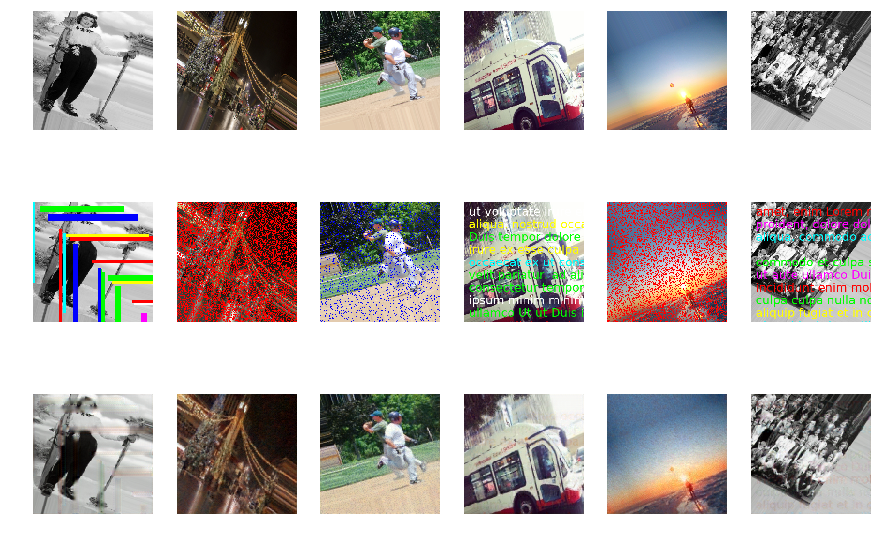

10 [D loss: 0.693509, acc: 34.38%] [G loss: 0.005804, mse: 0.005122]
20 [D loss: 0.699400, acc: 46.88%] [G loss: 0.004075, mse: 0.003394]
30 [D loss: 0.706259, acc: 40.62%] [G loss: 0.004608, mse: 0.003920]
40 [D loss: 0.697288, acc: 37.50%] [G loss: 0.004235, mse: 0.003541]
50 [D loss: 0.684913, acc: 50.00%] [G loss: 0.004463, mse: 0.003774]
60 [D loss: 0.685797, acc: 68.75%] [G loss: 0.004226, mse: 0.003522]
70 [D loss: 0.693738, acc: 46.88%] [G loss: 0.006040, mse: 0.005344]
80 [D loss: 0.692222, acc: 53.12%] [G loss: 0.005623, mse: 0.004947]
90 [D loss: 0.695976, acc: 56.25%] [G loss: 0.005214, mse: 0.004528]
100 [D loss: 0.699050, acc: 50.00%] [G loss: 0.005921, mse: 0.005227]
110 [D loss: 0.690866, acc: 46.88%] [G loss: 0.004663, mse: 0.003982]
120 [D loss: 0.696860, acc: 53.12%] [G loss: 0.005393, mse: 0.004699]
130 [D loss: 0.694678, acc: 43.75%] [G loss: 0.003916, mse: 0.003219]
140 [D loss: 0.697605, acc: 43.75%] [G loss: 0.004684, mse: 0.003999]
150 [D loss: 0.687233, acc: 5

W0504 12:29:48.114265  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 12:29:48.129897  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 12:29:48.129897  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 12:29:48.129897  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 12:29:48.145517  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


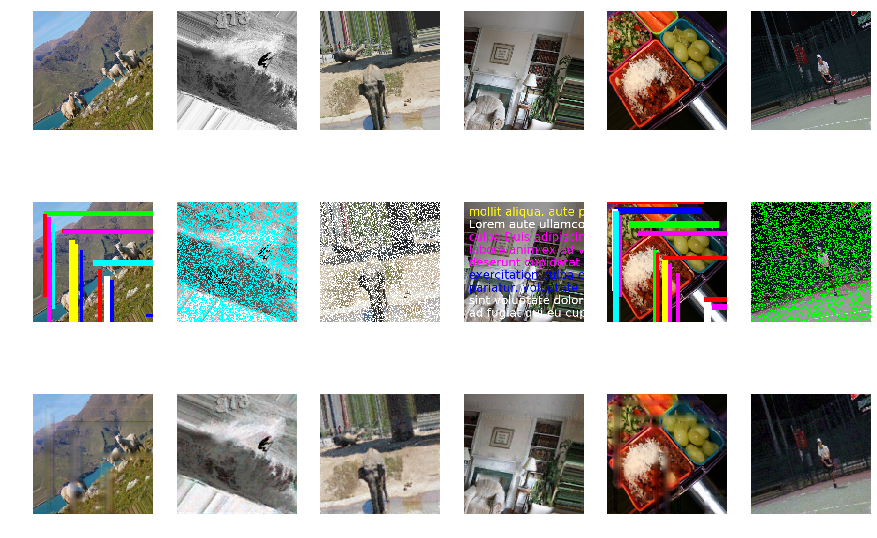

1010 [D loss: 0.693014, acc: 62.50%] [G loss: 0.004112, mse: 0.003442]
1020 [D loss: 0.691433, acc: 56.25%] [G loss: 0.004463, mse: 0.003782]
1030 [D loss: 0.696612, acc: 40.62%] [G loss: 0.005184, mse: 0.004502]
1040 [D loss: 0.687060, acc: 65.62%] [G loss: 0.005482, mse: 0.004797]
1050 [D loss: 0.697734, acc: 46.88%] [G loss: 0.005284, mse: 0.004594]
1060 [D loss: 0.694339, acc: 50.00%] [G loss: 0.004256, mse: 0.003561]
1070 [D loss: 0.696402, acc: 37.50%] [G loss: 0.003535, mse: 0.002843]
1080 [D loss: 0.700294, acc: 43.75%] [G loss: 0.004283, mse: 0.003595]
1090 [D loss: 0.699179, acc: 37.50%] [G loss: 0.004150, mse: 0.003467]
1100 [D loss: 0.698448, acc: 43.75%] [G loss: 0.004326, mse: 0.003630]
1110 [D loss: 0.688306, acc: 46.88%] [G loss: 0.004150, mse: 0.003464]
1120 [D loss: 0.692940, acc: 56.25%] [G loss: 0.005541, mse: 0.004843]
1130 [D loss: 0.693086, acc: 53.12%] [G loss: 0.005300, mse: 0.004609]
1140 [D loss: 0.694101, acc: 46.88%] [G loss: 0.005100, mse: 0.004411]
1150 [

W0504 12:49:51.900111  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 12:49:51.915739  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 12:49:51.915739  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 12:49:51.931360  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 12:49:51.931360  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


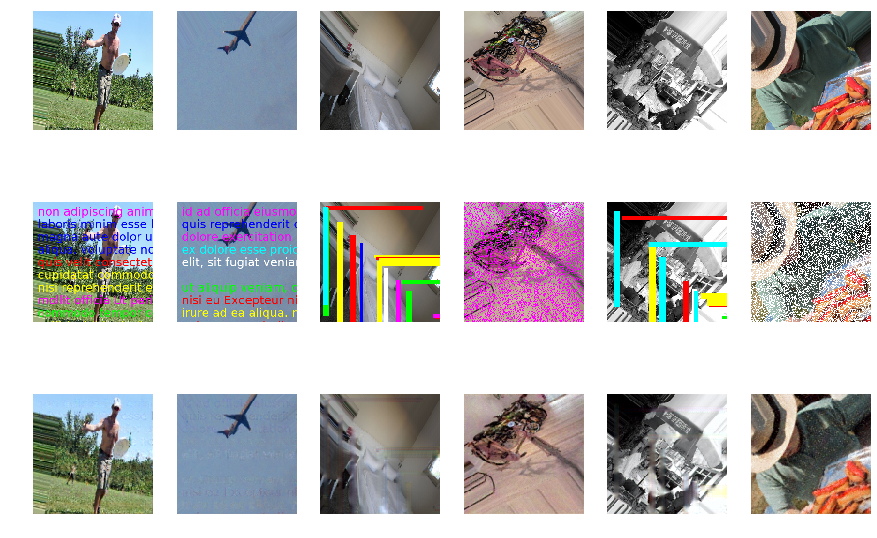

2010 [D loss: 0.694068, acc: 46.88%] [G loss: 0.004991, mse: 0.004305]
2020 [D loss: 0.688282, acc: 50.00%] [G loss: 0.003907, mse: 0.003219]
2030 [D loss: 0.696602, acc: 46.88%] [G loss: 0.004670, mse: 0.003970]
2040 [D loss: 0.692467, acc: 43.75%] [G loss: 0.005227, mse: 0.004539]
2050 [D loss: 0.692987, acc: 53.12%] [G loss: 0.004601, mse: 0.003911]
2060 [D loss: 0.693095, acc: 56.25%] [G loss: 0.005567, mse: 0.004877]
2070 [D loss: 0.692214, acc: 56.25%] [G loss: 0.004976, mse: 0.004284]
2080 [D loss: 0.693828, acc: 56.25%] [G loss: 0.004955, mse: 0.004260]
2090 [D loss: 0.687202, acc: 56.25%] [G loss: 0.004919, mse: 0.004227]
2100 [D loss: 0.691840, acc: 59.38%] [G loss: 0.005134, mse: 0.004437]
2110 [D loss: 0.693969, acc: 50.00%] [G loss: 0.005011, mse: 0.004322]
2120 [D loss: 0.699825, acc: 40.62%] [G loss: 0.004558, mse: 0.003870]
2130 [D loss: 0.699256, acc: 46.88%] [G loss: 0.003688, mse: 0.002993]
2140 [D loss: 0.694919, acc: 40.62%] [G loss: 0.003993, mse: 0.003305]
2150 [

W0504 13:09:54.591956  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 13:09:54.591956  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 13:09:54.607578  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 13:09:54.607578  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 13:09:54.623202  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 13:09:54.623202  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


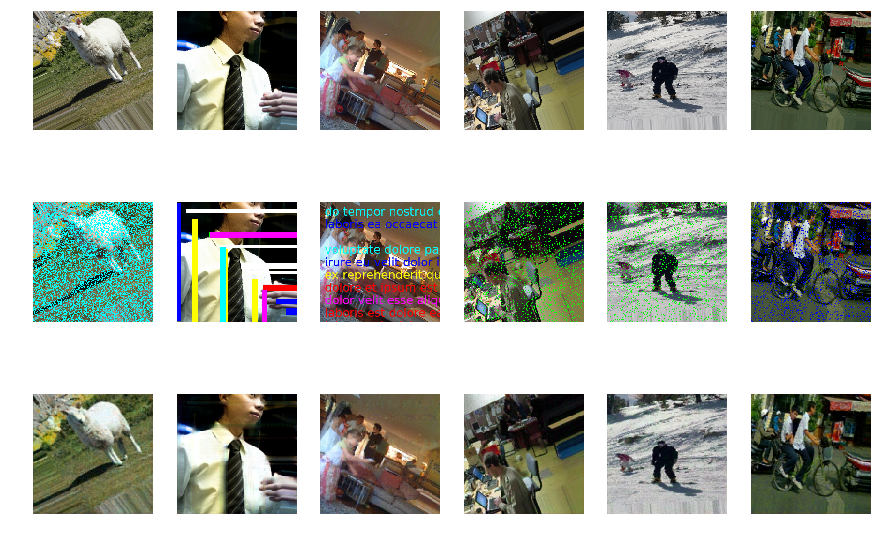

3010 [D loss: 0.689495, acc: 59.38%] [G loss: 0.005742, mse: 0.005052]
3020 [D loss: 0.691130, acc: 59.38%] [G loss: 0.004765, mse: 0.004074]
3030 [D loss: 0.696393, acc: 46.88%] [G loss: 0.004613, mse: 0.003919]
3040 [D loss: 0.698985, acc: 43.75%] [G loss: 0.004648, mse: 0.003962]
3050 [D loss: 0.692619, acc: 53.12%] [G loss: 0.005293, mse: 0.004591]
3060 [D loss: 0.692120, acc: 46.88%] [G loss: 0.005695, mse: 0.005005]
3070 [D loss: 0.690494, acc: 50.00%] [G loss: 0.004600, mse: 0.003915]
3080 [D loss: 0.692308, acc: 46.88%] [G loss: 0.004260, mse: 0.003570]
3090 [D loss: 0.694855, acc: 46.88%] [G loss: 0.005028, mse: 0.004337]
3100 [D loss: 0.693778, acc: 40.62%] [G loss: 0.004788, mse: 0.004098]
3110 [D loss: 0.694935, acc: 43.75%] [G loss: 0.006305, mse: 0.005619]
3120 [D loss: 0.698766, acc: 43.75%] [G loss: 0.004362, mse: 0.003680]
3130 [D loss: 0.699007, acc: 43.75%] [G loss: 0.004390, mse: 0.003698]
3140 [D loss: 0.697094, acc: 46.88%] [G loss: 0.005716, mse: 0.005024]
3150 [

W0504 13:30:23.507951  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 13:30:23.523575  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 13:30:23.523575  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 13:30:23.539201  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 13:30:23.539201  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


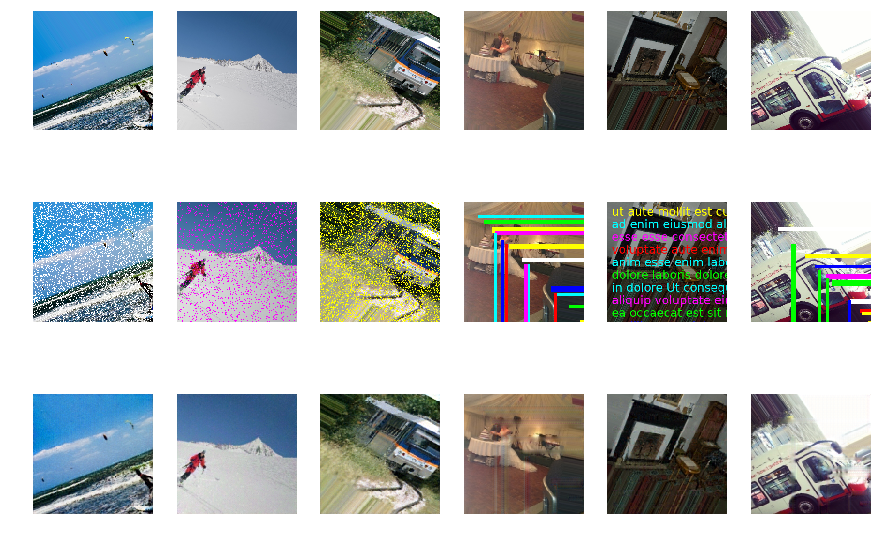

4010 [D loss: 0.694260, acc: 43.75%] [G loss: 0.005013, mse: 0.004328]
4020 [D loss: 0.690242, acc: 56.25%] [G loss: 0.004966, mse: 0.004281]
4030 [D loss: 0.689664, acc: 59.38%] [G loss: 0.004688, mse: 0.004014]
4040 [D loss: 0.697203, acc: 56.25%] [G loss: 0.005205, mse: 0.004513]
4050 [D loss: 0.698808, acc: 40.62%] [G loss: 0.003519, mse: 0.002827]
4060 [D loss: 0.699152, acc: 34.38%] [G loss: 0.003854, mse: 0.003160]
4070 [D loss: 0.690170, acc: 50.00%] [G loss: 0.004431, mse: 0.003736]
4080 [D loss: 0.689192, acc: 56.25%] [G loss: 0.004517, mse: 0.003833]
4090 [D loss: 0.693844, acc: 46.88%] [G loss: 0.005275, mse: 0.004573]
4100 [D loss: 0.693738, acc: 46.88%] [G loss: 0.005915, mse: 0.005229]
4110 [D loss: 0.695261, acc: 50.00%] [G loss: 0.005044, mse: 0.004359]
4120 [D loss: 0.694874, acc: 40.62%] [G loss: 0.004078, mse: 0.003387]
4130 [D loss: 0.694001, acc: 56.25%] [G loss: 0.004946, mse: 0.004246]
4140 [D loss: 0.692605, acc: 40.62%] [G loss: 0.004674, mse: 0.003985]
4150 [

W0504 13:50:33.399244  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 13:50:33.399244  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 13:50:33.414869  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 13:50:33.414869  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 13:50:33.414869  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


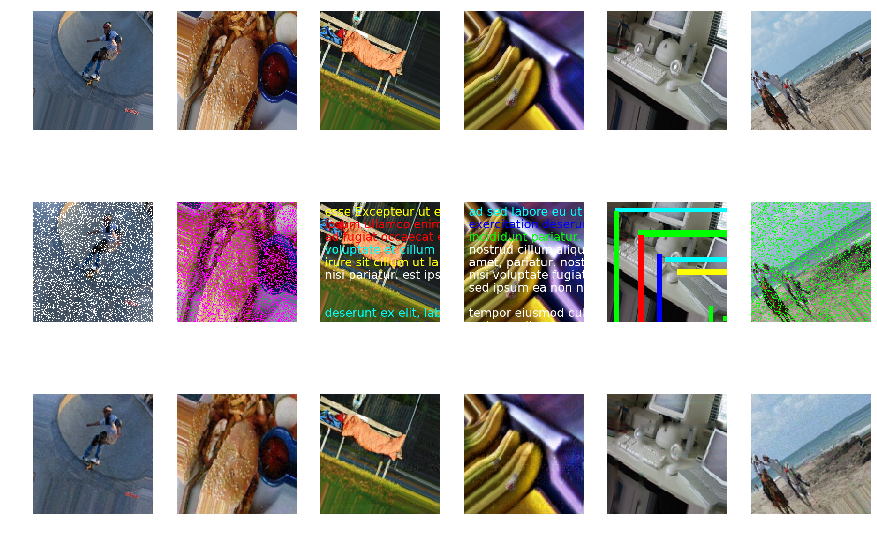

5010 [D loss: 0.694707, acc: 46.88%] [G loss: 0.004260, mse: 0.003587]
5020 [D loss: 0.694722, acc: 46.88%] [G loss: 0.004881, mse: 0.004196]
5030 [D loss: 0.691299, acc: 43.75%] [G loss: 0.005565, mse: 0.004884]
5040 [D loss: 0.687907, acc: 56.25%] [G loss: 0.005448, mse: 0.004762]
5050 [D loss: 0.696982, acc: 31.25%] [G loss: 0.004634, mse: 0.003953]
5060 [D loss: 0.688813, acc: 65.62%] [G loss: 0.004539, mse: 0.003847]
5070 [D loss: 0.696648, acc: 43.75%] [G loss: 0.005437, mse: 0.004746]
5080 [D loss: 0.691523, acc: 43.75%] [G loss: 0.005270, mse: 0.004582]
5090 [D loss: 0.690677, acc: 59.38%] [G loss: 0.005207, mse: 0.004518]
5100 [D loss: 0.694078, acc: 53.12%] [G loss: 0.004163, mse: 0.003468]
5110 [D loss: 0.693637, acc: 50.00%] [G loss: 0.005087, mse: 0.004393]
5120 [D loss: 0.699719, acc: 25.00%] [G loss: 0.004698, mse: 0.004010]
5130 [D loss: 0.691851, acc: 59.38%] [G loss: 0.005738, mse: 0.005051]
5140 [D loss: 0.691772, acc: 43.75%] [G loss: 0.004807, mse: 0.004119]
5150 [

W0504 14:10:56.620523  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 14:10:56.620523  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 14:10:56.620523  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 14:10:56.636144  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 14:10:56.636144  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 14:10:56.636144  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


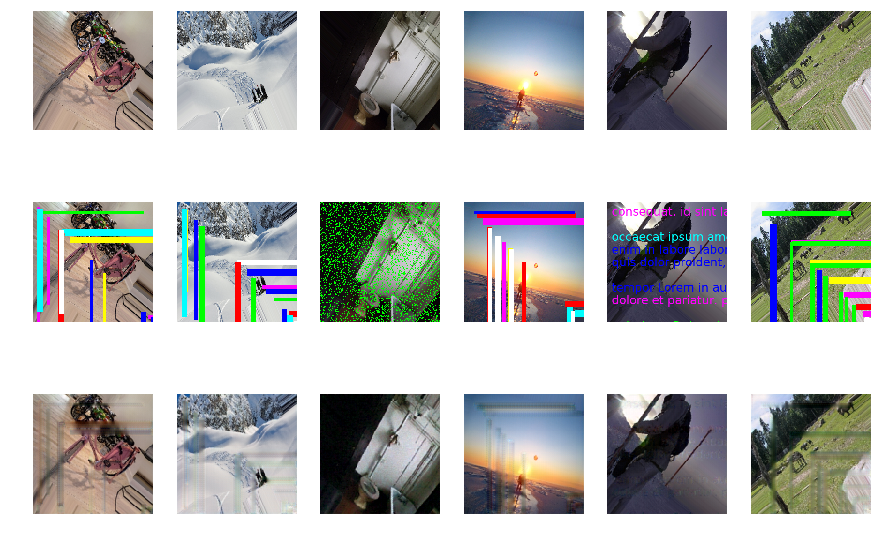

6010 [D loss: 0.693418, acc: 46.88%] [G loss: 0.005059, mse: 0.004370]
6020 [D loss: 0.689521, acc: 65.62%] [G loss: 0.004460, mse: 0.003779]
6030 [D loss: 0.693713, acc: 46.88%] [G loss: 0.005040, mse: 0.004356]
6040 [D loss: 0.687895, acc: 59.38%] [G loss: 0.004709, mse: 0.004020]
6050 [D loss: 0.697862, acc: 43.75%] [G loss: 0.003778, mse: 0.003087]
6060 [D loss: 0.687565, acc: 56.25%] [G loss: 0.004506, mse: 0.003812]
6070 [D loss: 0.693637, acc: 46.88%] [G loss: 0.003891, mse: 0.003204]
6080 [D loss: 0.697659, acc: 53.12%] [G loss: 0.003346, mse: 0.002656]
6090 [D loss: 0.696772, acc: 46.88%] [G loss: 0.004437, mse: 0.003749]
6100 [D loss: 0.695423, acc: 43.75%] [G loss: 0.004916, mse: 0.004230]
6110 [D loss: 0.686807, acc: 59.38%] [G loss: 0.003859, mse: 0.003164]
6120 [D loss: 0.694721, acc: 37.50%] [G loss: 0.003864, mse: 0.003169]
6130 [D loss: 0.698560, acc: 43.75%] [G loss: 0.003622, mse: 0.002935]
6140 [D loss: 0.688479, acc: 53.12%] [G loss: 0.005354, mse: 0.004663]
6150 [

W0504 14:31:01.790394  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 14:31:01.790394  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 14:31:01.790394  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 14:31:01.806016  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 14:31:01.806016  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 14:31:01.806016  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


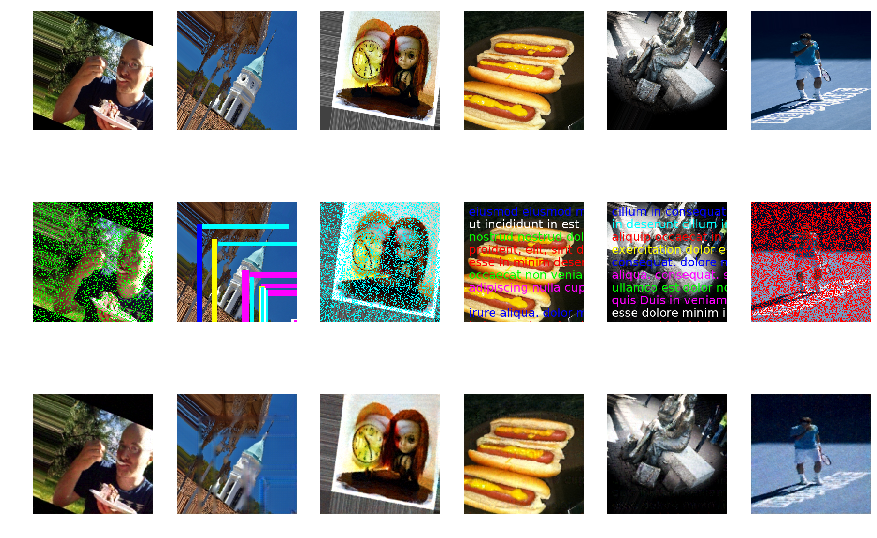

7010 [D loss: 0.693660, acc: 50.00%] [G loss: 0.005188, mse: 0.004495]
7020 [D loss: 0.700624, acc: 37.50%] [G loss: 0.004454, mse: 0.003760]
7030 [D loss: 0.694102, acc: 50.00%] [G loss: 0.004349, mse: 0.003657]
7040 [D loss: 0.697989, acc: 37.50%] [G loss: 0.003865, mse: 0.003183]
7050 [D loss: 0.691876, acc: 56.25%] [G loss: 0.004418, mse: 0.003721]
7060 [D loss: 0.690112, acc: 65.62%] [G loss: 0.004325, mse: 0.003633]
7070 [D loss: 0.694756, acc: 50.00%] [G loss: 0.004910, mse: 0.004222]
7080 [D loss: 0.693319, acc: 53.12%] [G loss: 0.004810, mse: 0.004124]
7090 [D loss: 0.691694, acc: 46.88%] [G loss: 0.005197, mse: 0.004508]
7100 [D loss: 0.696166, acc: 46.88%] [G loss: 0.004309, mse: 0.003614]
7110 [D loss: 0.688909, acc: 50.00%] [G loss: 0.004940, mse: 0.004252]
7120 [D loss: 0.698210, acc: 43.75%] [G loss: 0.004408, mse: 0.003712]
7130 [D loss: 0.690792, acc: 56.25%] [G loss: 0.003927, mse: 0.003238]
7140 [D loss: 0.696246, acc: 46.88%] [G loss: 0.004949, mse: 0.004253]
7150 [

W0504 14:51:07.179031  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 14:51:07.179031  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 14:51:07.179031  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 14:51:07.194641  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 14:51:07.194641  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 14:51:07.194641  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


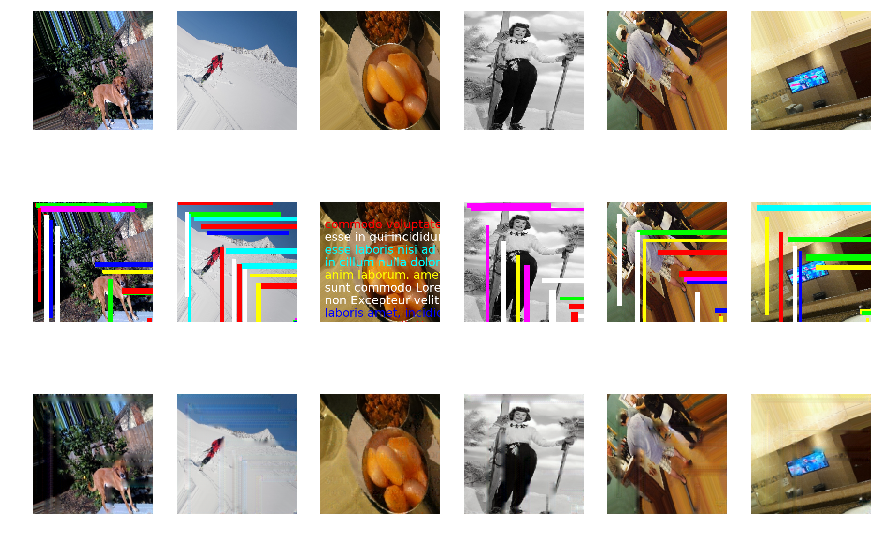

8010 [D loss: 0.695241, acc: 40.62%] [G loss: 0.003781, mse: 0.003089]
8020 [D loss: 0.687519, acc: 53.12%] [G loss: 0.004296, mse: 0.003601]
8030 [D loss: 0.689507, acc: 59.38%] [G loss: 0.004497, mse: 0.003812]
8040 [D loss: 0.697627, acc: 37.50%] [G loss: 0.006463, mse: 0.005777]
8050 [D loss: 0.689387, acc: 65.62%] [G loss: 0.004569, mse: 0.003879]
8060 [D loss: 0.697000, acc: 46.88%] [G loss: 0.004002, mse: 0.003323]
8070 [D loss: 0.695626, acc: 46.88%] [G loss: 0.004415, mse: 0.003726]
8080 [D loss: 0.697702, acc: 31.25%] [G loss: 0.003647, mse: 0.002956]
8090 [D loss: 0.693264, acc: 46.88%] [G loss: 0.003947, mse: 0.003255]
8100 [D loss: 0.694296, acc: 43.75%] [G loss: 0.005855, mse: 0.005166]
8110 [D loss: 0.696595, acc: 46.88%] [G loss: 0.005296, mse: 0.004609]
8120 [D loss: 0.693820, acc: 56.25%] [G loss: 0.004443, mse: 0.003756]
8130 [D loss: 0.696325, acc: 40.62%] [G loss: 0.004846, mse: 0.004156]
8140 [D loss: 0.692431, acc: 53.12%] [G loss: 0.003183, mse: 0.002498]
8150 [

W0504 15:11:54.686694  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 15:11:54.708685  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 15:11:54.720681  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 15:11:54.730679  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 15:11:54.781661  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 15:11:54.801656  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


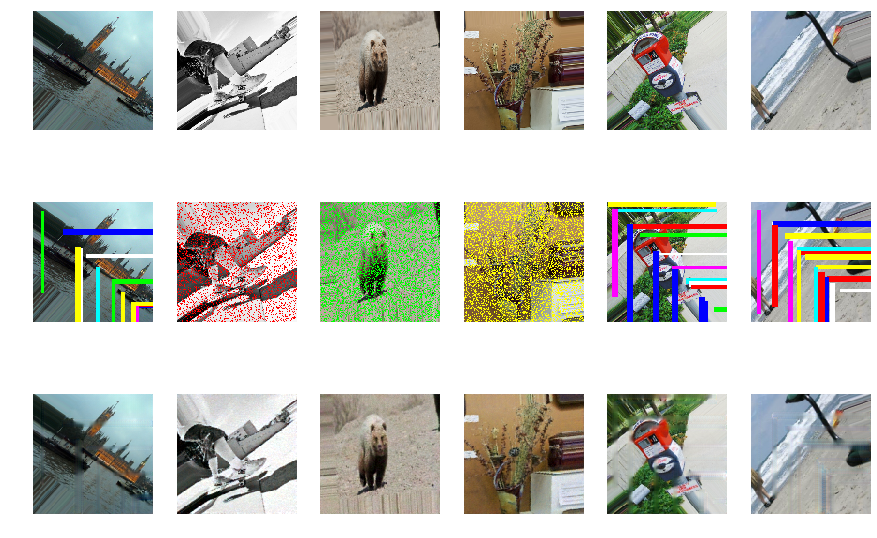

9010 [D loss: 0.693633, acc: 46.88%] [G loss: 0.004165, mse: 0.003480]
9020 [D loss: 0.694589, acc: 37.50%] [G loss: 0.005127, mse: 0.004437]
9030 [D loss: 0.692323, acc: 43.75%] [G loss: 0.005114, mse: 0.004427]
9040 [D loss: 0.693909, acc: 50.00%] [G loss: 0.005410, mse: 0.004727]
9050 [D loss: 0.692436, acc: 56.25%] [G loss: 0.005066, mse: 0.004373]
9060 [D loss: 0.691322, acc: 56.25%] [G loss: 0.005122, mse: 0.004440]
9070 [D loss: 0.692738, acc: 56.25%] [G loss: 0.004047, mse: 0.003355]
9080 [D loss: 0.694187, acc: 43.75%] [G loss: 0.005746, mse: 0.005052]
9090 [D loss: 0.688197, acc: 59.38%] [G loss: 0.005300, mse: 0.004607]
9100 [D loss: 0.697443, acc: 37.50%] [G loss: 0.004633, mse: 0.003945]
9110 [D loss: 0.696519, acc: 37.50%] [G loss: 0.003877, mse: 0.003185]
9120 [D loss: 0.695054, acc: 31.25%] [G loss: 0.004594, mse: 0.003907]
9130 [D loss: 0.693869, acc: 50.00%] [G loss: 0.005480, mse: 0.004789]
9140 [D loss: 0.695606, acc: 53.12%] [G loss: 0.004637, mse: 0.003943]
9150 [

W0504 15:33:52.535687  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 15:33:52.542682  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 15:33:52.551681  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 15:33:52.558678  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 15:33:52.566674  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
W0504 15:33:52.574843  9452 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


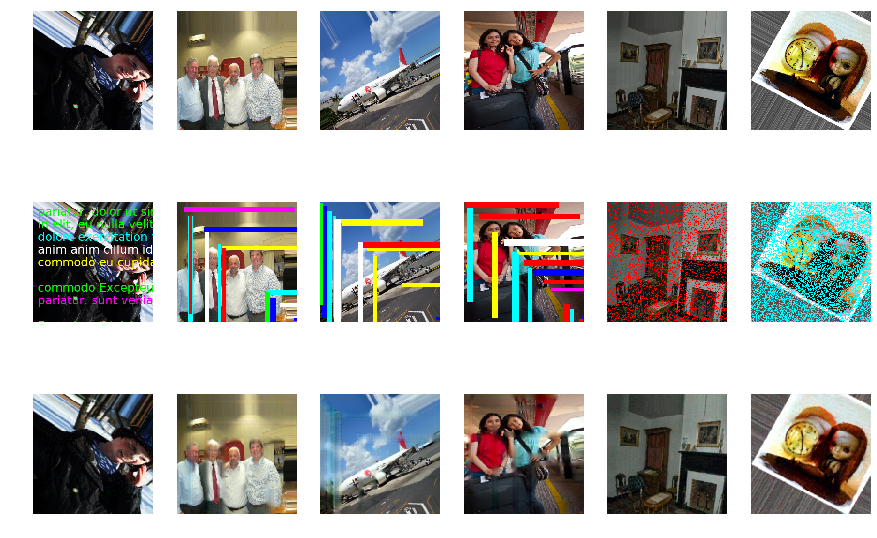

10010 [D loss: 0.690565, acc: 43.75%] [G loss: 0.004374, mse: 0.003689]
10020 [D loss: 0.692255, acc: 62.50%] [G loss: 0.003999, mse: 0.003319]
10030 [D loss: 0.689587, acc: 53.12%] [G loss: 0.004400, mse: 0.003708]
10040 [D loss: 0.692995, acc: 53.12%] [G loss: 0.005496, mse: 0.004805]
10050 [D loss: 0.699267, acc: 34.38%] [G loss: 0.003492, mse: 0.002805]
10060 [D loss: 0.692591, acc: 59.38%] [G loss: 0.004866, mse: 0.004180]
10070 [D loss: 0.692887, acc: 50.00%] [G loss: 0.004662, mse: 0.003971]
10080 [D loss: 0.690347, acc: 59.38%] [G loss: 0.005201, mse: 0.004519]
10090 [D loss: 0.694831, acc: 50.00%] [G loss: 0.004280, mse: 0.003584]
10100 [D loss: 0.693503, acc: 53.12%] [G loss: 0.005413, mse: 0.004724]
10110 [D loss: 0.695793, acc: 50.00%] [G loss: 0.005778, mse: 0.005093]
10120 [D loss: 0.699475, acc: 43.75%] [G loss: 0.005285, mse: 0.004601]
10130 [D loss: 0.691618, acc: 43.75%] [G loss: 0.003822, mse: 0.003130]
10140 [D loss: 0.693129, acc: 46.88%] [G loss: 0.004156, mse: 0.

KeyboardInterrupt: 

In [16]:
# Adversarial ground truths
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for step in range(60000):
    original = next(train_generator)
    masked_images = mask_randomly(original)
    
    # Generate images
    gen = generator.predict(masked_images)
        
    # Train discriminator with the generated images
    discriminator.trainable = True
    d_loss_real = discriminator.train_on_batch(original, valid)
    d_loss_fake = discriminator.train_on_batch(gen, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
    # Train LSGAN
    discriminator.trainable = False
    g_loss = lsgan.train_on_batch(masked_images, [original, valid])
    
    if step % 10 == 0:
        print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % (step, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))
    
    if step % 1000 == 0:
        original = next(val_generator)
        masked_images = mask_randomly(original)
        sample_images(masked_images, original)
        
    if step % 200 == 0:
        train_generator.reset()
        val_generator.reset()
        save(lsgan, 'lsgan')